# MultiNest sampling

This example demonstrates how to use MultiNest sampling [1] to sample from the posterior distribution for a logistic model fitted to model-simulated data.

[1] "MultiNest: an efficient and robust Bayesian inference tool for cosmology and particle physics."
Feroz, F., M. P. Hobson, and M. Bridges. Monthly Notices of the Royal Astronomical Society 398.4 (2009): 1601-1614.

MultiNest works similarly to [ellipsoidal nested sampling](nested-ellipsoidal-sampling.ipynb) by proposing points using the prior but constraining the proposals such that they lie within ellipsoids of known high density. A key difference is that MultiNest uses (potentially) a number of ellipsoids to generate proposals, unlike ellipsoidal nested sampling, which uses only a single ellipsoid.

We illustrate this using the `Ellipsoid()` and `EllipsoidTree()` classes in PINTS. Whilst users do not need these to perform inference, we use them here to visualise the ellipses generated by fitting to two-dimensional data.

We first generate some sample data which we'll fit bounding ellipses to.

In [1]:
import os
os.chdir("../..")
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt

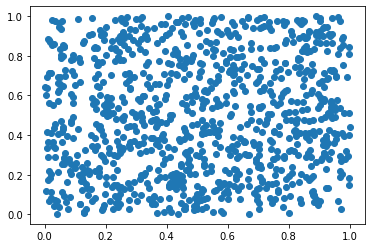

In [2]:
n = 1000
gaussian = pints.MultivariateGaussianLogPrior([0, 0], [[1, 0], [0, 1]])
draws = gaussian.sample(n)
draws = [gaussian.convert_to_unit_cube(x) for x in draws]

draws = np.vstack(draws)
plt.scatter(draws[:, 0], draws[:, 1])
plt.show()

In [3]:
def plot_2d_ellipsoid(ellipsoid):
    A = ellipsoid.weight_matrix()
    c = ellipsoid.centroid()

    U, D, V = np.linalg.svd(A)

    # major and minor axes
    a = 1 / np.sqrt(D[0])
    b = 1 / np.sqrt(D[1])

    # generate x and y
    theta = np.linspace(0, 2 * np.pi, 1000)
    state_1 = a * np.cos(theta)
    state_2 = b * np.sin(theta)
    state = np.vstack((state_1, state_2))
    z = np.matmul(V, state)
    x = z[0, :] + c[0]
    y = z[1, :] + c[1]

    plt.plot(x, y)

def plot_2d_ellipsoid_tree_leaves(ellipsoid_tree):
    ellipsoids = ellipsoid_tree.leaf_ellipsoids()
    for ellipsoid in ellipsoids:
        plot_2d_ellipsoid(ellipsoid)

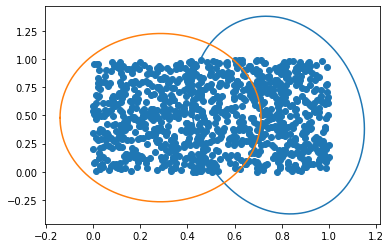

In [4]:
from pints._nested.__init__ import Ellipsoid
from pints._nested._multinest import EllipsoidTree

ellipsoid_tree = EllipsoidTree(draws, 1)

plot_2d_ellipsoid_tree_leaves(ellipsoid_tree)
plt.scatter(draws[:, 0], draws[:, 1])
plt.show()

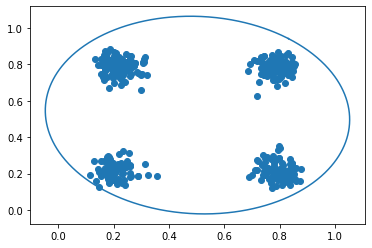

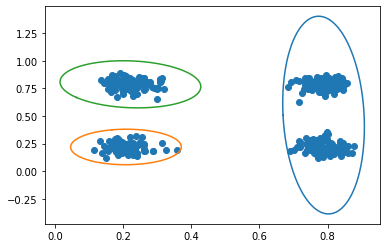

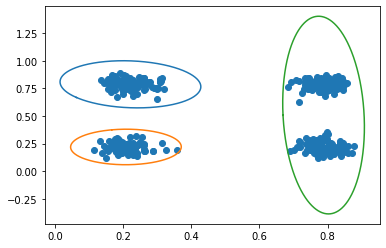

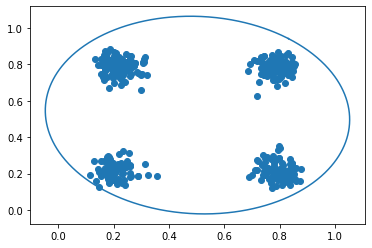

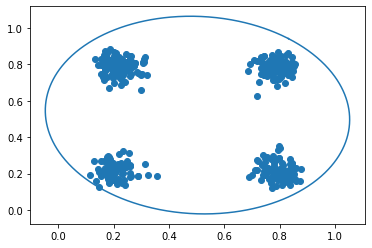

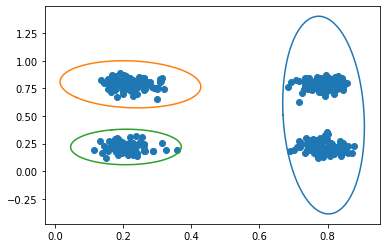

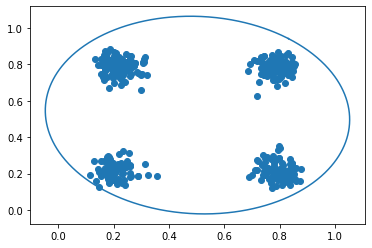

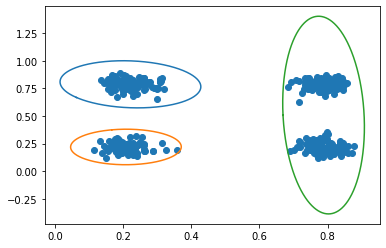

In [5]:
n = 400
sigma = 2
r = 4
gaussian = pints.MultivariateGaussianLogPrior([0, 0], [[100, 0], [0, 100]])
log_pdf = pints.toy.SimpleEggBoxLogPDF(sigma, r)
draws = log_pdf.sample(n)
draws = [gaussian.convert_to_unit_cube(x) for x in draws]

draws = np.vstack(draws)

nreps = 8
for i in range(nreps):
    ellipsoid_tree = EllipsoidTree(draws, 220)

    plot_2d_ellipsoid_tree_leaves(ellipsoid_tree)
    plt.scatter(draws[:, 0], draws[:, 1])
    plt.show()

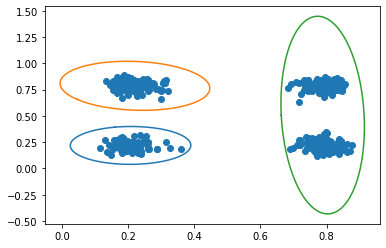

In [15]:
ellipsoid_tree = EllipsoidTree(draws, 200)

plot_2d_ellipsoid_tree_leaves(ellipsoid_tree)
plt.scatter(draws[:, 0], draws[:, 1])
plt.show()

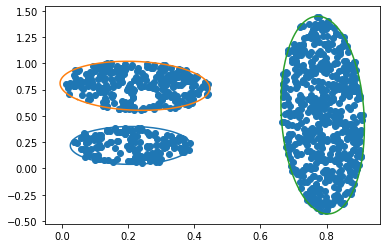

In [16]:
test_draws = ellipsoid_tree.sample_leaf_ellipsoids(1000)
test_draws = np.vstack(test_draws)

plot_2d_ellipsoid_tree_leaves(ellipsoid_tree)
plt.scatter(test_draws[:, 0], test_draws[:, 1])
plt.show()

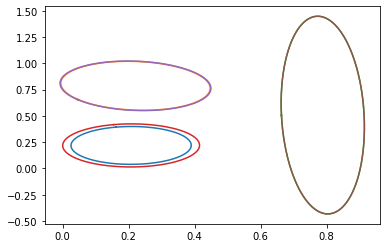

In [17]:
plot_2d_ellipsoid_tree_leaves(ellipsoid_tree)
ellipsoid_tree.update_leaf_ellipsoids(300)
plot_2d_ellipsoid_tree_leaves(ellipsoid_tree)
plt.show()

In [69]:
volumes = [ell.volume() for ell in ellipsoid_tree.leaf_ellipsoids()]
volume_tot = sum(volumes)
volumes_rel = [vol / volume_tot for vol in volumes]
np.random.choice(len(volumes), p=volumes_rel)

0

# Egg box problem

In [15]:
class ExampleToy(pints.LogPDF):
    def __init__(self, sigma, r):
        self._sigma = sigma
        self._r = r
        self._log_toy = pints.toy.SimpleEggBoxLogPDF(self._sigma, self._r)

    def __call__(self, x):
        x1 = np.copy(x)
        x1[0] = -15 + 30 * x[0]
        x1[1] = -15 + 30 * x[1]
        return self._log_toy(x1)

    def n_parameters(self):
        return 2

In [16]:
log_pdf = ExampleToy(2, 4)
log_prior = pints.UniformLogPrior(
    [0.0, 0.0],
    [1.0, 1.0])

In [17]:
sampler = pints.NestedController(log_pdf, log_prior, method=pints.MultinestSampler)

# Set number of iterations
sampler.set_iterations(1000)

# Set the number of posterior samples to generate
sampler.set_n_posterior_samples(500)

sampler._sampler.set_f_s_threshold(8)

In [18]:
samples = sampler.run()
print('Done!')

Running MultiNest sampler
Number of active points: 400
Total number of iterations: 1000
Total number of posterior samples: 500
Iter. Eval. Time m:s Delta_log(z) Acceptance rate Ellipsoid count
0     1       0:00.0 -inf          1               0             
0     2       0:00.0 -inf          1               0             
0     21      0:00.0 -inf          1               0             
0     41      0:00.0 -inf          1               0             
0     61      0:00.0 -inf          1               0             
0     81      0:00.0 -inf          1               0             
0     101     0:00.0 -inf          1               0             
0     121     0:00.0 -inf          1               0             
0     141     0:00.0 -inf          1               0             
0     161     0:00.1 -inf          1               0             
0     181     0:00.1 -inf          1               0             
0     201     0:00.1 -inf          1               0             
0     221     0

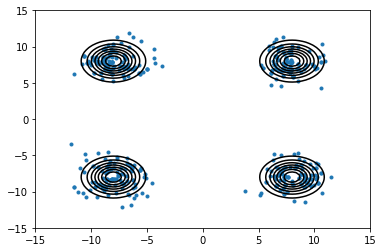

In [19]:
sigma = 2
r = 4
log_pdf = pints.toy.SimpleEggBoxLogPDF(sigma, r)

# Contour plot of pdf
levels = np.linspace(-100, 0, 20)
x = np.linspace(-15, 15, 100)
y = np.linspace(-15, 15, 100)
X, Y = np.meshgrid(x, y)
Z = [[np.exp(log_pdf([i, j])) for i in x] for j in y]

plt.figure()
plt.contour(X, Y, Z, colors='k')
plt.scatter(-15 + 30 * samples[:, 0], -15 + 30 * samples[:, 1], marker='.')
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.show()

In [20]:
print('effective sample size = ' + str(sampler.effective_sample_size()))

effective sample size = 686.201302141924


In [21]:
print('marginal log-likelihood = ' + str(sampler.marginal_log_likelihood())
      + ' ± ' + str(sampler.marginal_log_likelihood_standard_deviation()))

marginal log-likelihood = -5.354139172162014 ± 0.06802787132484504
